### Setup

#### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PW_explorer.load_worlds import load_worlds
from PW_explorer.run_clingo import run_clingo
from PW_explorer.visualize import PWEVisualization
from PW_explorer.helper import pw_slicer, rel_slicer, rel_name_remapper
from PW_explorer.export import PWEExport
from PWE_NB_Extension.helper import ASPRules
import pandas as pd
import os
from misc import *
from DLV_Input_Parser.dlv_rules_parser import parse_dlv_rules

In [3]:
import networkx as nx
from nxpd import draw
import nxpd
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

In [4]:
%load_ext PWE_NB_Extension

#### Helper Functions

In [5]:
def save_query_figs(query_analysis, folder='fork2_all_patterns_new'):
    fnames = {}
    os.makedirs(folder, exist_ok=True)
    for pw_id in range(1, len(query_analysis['pw_objs'])+1):
        pw_rel_dfs, pw_objs = pw_slicer(query_analysis['pw_rel_dfs'], query_analysis['pw_objs'], [pw_id])
        pw_obj = pw_objs[0]

        node_fig_g = get_pattern_graph3(pw_rel_dfs, pw_obj, silent=True, 
                                        q_head='none', 
                                        chain_eq_node_labels=False)
        q_str = print_rewritten_query_string(pw_rel_dfs, html=False, display_q=False, include_ineqls=False)
        q_str = q_str.replace('thop', 'q')
        node_fig_g.graph['label'] = q_str
        node_fig_g.graph['labelloc'] = 't' # options 't', 'b'
        fname = '{}.{}'.format('{}/pw_{}'.format(folder, pw_id), 'png')
        fname_gv = '{}.{}'.format('{}/pw_{}'.format(folder, pw_id), 'gv')
        draw(node_fig_g, filename=fname, show=False)
        draw(node_fig_g, filename=fname_gv, show=False)
        fnames[pw_id] = fname
    return fnames

#### Supplementary ASP Encodings

In [6]:
%%clingo --donot-display_input --donot-run -lci query_analysis_suppl

% schema ruleOccTrue(ATOM, OCC)
ruleOccTrue(R, OC) :- ruleOcc(R, OC).
% schema ruleHTrue(HEAD)
ruleHTrue(H)  :- ruleH(H).
% schema newVar(VAR, DOMAIN)
newVar(VAR, TYPE) :- var(VAR, TYPE), not eqOrd(_,VAR,TYPE).
% schema eqOrdMinimal(VAR1, VAR2, DOMAIN)
eqOrdMinimal(A,B,TYPE) :- eqOrd(A,B,TYPE), newVar(A,TYPE).
% schema neqOrd(VAR1, VAR2, DOMAIN)
neqOrd(A,B,TYPE) :- newVar(A,TYPE), newVar(B,TYPE), A<B.

% New inferred edges
% schema e(NODE1, NODE2)
e(V1,V2) :- newArc(V1, 1, e, OCC), newArc(V2, 2, e, OCC).
% schema e(OCC, NODE1, NODE2)
e(OCC,V1,V2) :- newArc(V1, 1, e, OCC), newArc(V2, 2, e, OCC).
    
%graphviz graph graph_type=directed rankdir=LR
%graphviz edge newArc(HEAD, _, TAIL) label=$2
%graphviz node ruleOccTrue(N) color=green

#show ruleOccTrue/2.
#show ruleHTrue/1.
#show var/2.
#show newVar/2.
#show ruleOcc/2.
#show ruleH/1.
#show eqOrd/3.
#show neqOrd/3.
#show eqOrdMinimal/3.
#show arc/4.
#show newArc/4.
#show hArc/3.
#show newHArc/3.
#show e/2.
#show e/3.

### Query Analysis

Say we want to statically analyze the symm_3hop/2 query:

__fork(X,Y) :- e(X,Y), e(Y,Z1), e(Y,Z2).__

To do this, we first encode the query as a incidence graph as shown below:

In [7]:
query_str = "fork(X,Y) :- e(X,Y), e(Y,Z1), e(Y,Z2)."

In [8]:
def get_query_incidence_graph_encoding(asp_rule):
    listener = parse_dlv_rules(asp_rule, print_parse_tree=False)
    
    schema_defs = [
        '% schema var(VAR, DOMAIN).',
        '% schema ruleOcc(ATOM, OCC).',
        '% schema ruleH(HEAD).',
        '% schema arc(VAR, POS, ATOM, OCC).',
        '% schema hArc(VAR, POS, HEAD).',
    ]
    rule_vars = set([])
    rule_occ_nodes = []
    rule_inc_edges = []
    rule_head_nodes = []
    head_inc_edges = []
    
    
    assert len(listener.rules) == 1
    
    for rule in listener.rules:
        head_atoms, tail_atoms = rule[0], rule[1]
        
        for i, ruleOcc in enumerate(tail_atoms):
            rule_vars.update(set(ruleOcc.vars))
            rule_occ_nodes.append(f'ruleOcc({ruleOcc.rel_name}, {i+1}).')
            for j, ruleOcc_v in enumerate(ruleOcc.vars):
                rule_inc_edges.append(f'arc("{ruleOcc_v}", {j+1}, {ruleOcc.rel_name}, {i+1}).')

        for i, ruleH in enumerate(head_atoms):
            rule_vars.update(set(ruleH.vars))
            rule_head_nodes.append(f'ruleH({ruleH.rel_name}).')
            for j, ruleH_v in enumerate(ruleH.vars):
                head_inc_edges.append(f'hArc("{ruleH_v}", {j+1}, {ruleH.rel_name}).')
    
    var_nodes = [f'var("{v}", node).' for v in rule_vars]
    
    return schema_defs + var_nodes + rule_occ_nodes + rule_inc_edges + rule_head_nodes + head_inc_edges

In [9]:
thop_query_desc = get_query_incidence_graph_encoding(query_str)
ASPRules(thop_query_desc)

'% schema var(VAR, DOMAIN).\n% schema ruleOcc(ATOM, OCC).\n% schema ruleH(HEAD).\n% schema arc(VAR, POS, ATOM, OCC).\n% schema hArc(VAR, POS, HEAD).\nvar("Z1", node).\nvar("X", node).\nvar("Y", node).\nvar("Z2", node).\nruleOcc(e, 1).\nruleOcc(e, 2).\nruleOcc(e, 3).\narc("X", 1, e, 1).\narc("Y", 2, e, 1).\narc("Y", 1, e, 2).\narc("Z1", 2, e, 2).\narc("Y", 1, e, 3).\narc("Z2", 2, e, 3).\nruleH(fork).\nhArc("X", 1, fork).\nhArc("Y", 2, fork).'

Next we encode the query analysis code that uses a query description such as the one above.

Within this analysis, we create Bell-Number(n) (i.e. B<sub>n</sub>) many partitions where n is the number of distinct variable in the query.

Then we recreate a new incidence graph where the we substitute each disjoint group in the partition with a representative variable (for simplicity, we use the lexicographically smallest variable).

In [10]:
%%clingo --donot-display_input -lci query_analysis_enc --donot-run

% Create variable partitions
% schema eq(VAR1, VAR2, DOMAIN)
eq(A,B,TYPE) ; not eq(A,B,TYPE) :- var(A, TYPE), var(B, TYPE), A!=B.
eq(A,B,TYPE) :- eq(B,A,TYPE).
eq(A,B,TYPE) :- eq(A,C,TYPE), eq(C,B,TYPE), A!=B, B!=C, A!=C.

% Order the individual partitions
% schema eqOrd(VAR1, VAR2, DOMAIN)
eqOrd(A,B,TYPE) :- eq(A,B,TYPE), A<B.

% Find the new arcs, getting rid of the redundant variables as per the orderings
% schema newArc(VAR, POS, ATOM, OCC)
newArc(VAR, POS, ATOM, OCC) :- arc(VAR_ORIG, POS, ATOM, OCC), eqOrd(VAR,VAR_ORIG,TYPE), not eqOrd(_,VAR,TYPE).
newArc(VAR, POS, ATOM, OCC) :- arc(VAR, POS, ATOM, OCC), not eqOrd(_,VAR,_).

% schema newHArc(VAR, POS, HEAD)
newHArc(VAR, POS, H) :- hArc(VAR_ORIG,POS,H), eqOrd(VAR,VAR_ORIG,TYPE), not eqOrd(_,VAR,TYPE).
newHArc(VAR, POS, H) :- hArc(VAR, POS, H), not eqOrd(_,VAR,_).

With these two encodings, we can create the specialized queries that make up the original query.

For clarity, let's project out the resultant e/2 and thop/2 relation that make up the query:

In [11]:
%%clingo --donot-display_input -l query_analysis_enc thop_query_desc

e(V1,V2) :- newArc(V1, 1, e, OCC), newArc(V2, 2, e, OCC).
thop(V1,V2) :- newHArc(V1,1,thop), newHArc(V2,2,thop).
#show e/2.
#show thop/2.

Output:


'Answer: 1\ne("X","Y") e("Y","Z1") e("Y","Z2")\nAnswer: 2\ne("X","Y") e("Y","Z1")\nAnswer: 3\ne("X","Y") e("Y","Y") e("Y","Z1")\nAnswer: 4\ne("Y","X") e("X","Y") e("Y","Z1")\nAnswer: 5\ne("X","Y") e("Y","Y") e("Y","Z2")\nAnswer: 6\ne("X","Y") e("Y","Y")\nAnswer: 7\ne("Y","X") e("X","Y") e("Y","Y")\nAnswer: 8\ne("Y","X") e("X","Y") e("Y","Z2")\nAnswer: 9\ne("Y","X") e("X","Y") e("Y","Y")\nAnswer: 10\ne("Y","X") e("X","Y")\nAnswer: 11\ne("X","X") e("X","Z1") e("X","Z2")\nAnswer: 12\ne("X","X") e("X","Z1")\nAnswer: 13\ne("X","X") e("X","Z1")\nAnswer: 14\ne("X","X") e("X","Z2")\nAnswer: 15\ne("X","X")\nSATISFIABLE\n\nModels       : 15\nCalls        : 1\nTime         : 0.003s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.003s'

As we can see, we get B<sub>4</sub> (= 15) PWs. The outputs above showcase a canonical database that would satisfy the specialized query that these PWs represent.

First we load these PWs in using the PWE Tool.

In [12]:
%clingo --donot-display_input --donot-display_output -l query_analysis_enc thop_query_desc query_analysis_suppl -exp query_analysis

In [13]:
query_analysis['pw_rel_dfs'], query_analysis['rel_schema'], query_analysis['pw_objs'] =load_worlds(query_analysis['asp_soln'],
                                                                                                   query_analysis['meta_data'])


Number of Models: 15


In [14]:
if 'hArc_3' not in query_analysis['pw_rel_dfs']:
    query_analysis['pw_rel_dfs']['hArc_3'] = pd.DataFrame(columns=['pw', 'VAR', 'POS', 'HEAD'])
if 'newHArc_3' not in query_analysis['pw_rel_dfs']:
    query_analysis['pw_rel_dfs']['newHArc_3'] = pd.DataFrame(columns=['pw', 'VAR', 'POS', 'HEAD'])
for i in range(len(query_analysis['pw_objs'])):
    if 'hArc_3' not in query_analysis['pw_objs'][i].rls:
        query_analysis['pw_objs'][i].rls['hArc_3'] = []
    if 'newHArc_3' not in query_analysis['pw_objs'][i].rls:
        query_analysis['pw_objs'][i].rls['newHArc_3'] = []
    if 'ruleHTrue_1' not in query_analysis['pw_objs'][i].rls:
        query_analysis['pw_objs'][i].rls['ruleHTrue_1'] = []

With some simple python and ASP magic, we can create these specialized queries, their canonical databases and visualize the graph patterns these canonical databases represent.

------------------------------------------------------------

PW: 1

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","Y"). e("Y","Z1"). e("Y","Z2"). fork("X","Y").


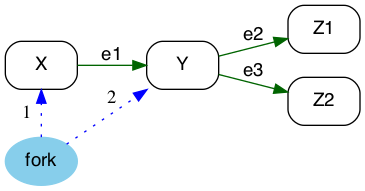

------------------------------------------------------------
------------------------------------------------------------

PW: 2

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","Y"). e("Y","Y"). e("Y","Z1"). fork("X","Y").


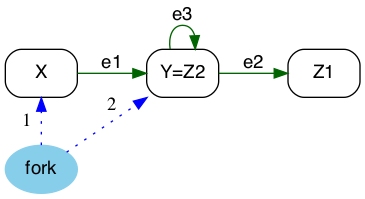

------------------------------------------------------------
------------------------------------------------------------

PW: 3

Partitioning Description:


Specialized Query:


Canonical DB:
e("Y","X"). e("X","Y"). e("Y","Z1"). fork("X","Y").


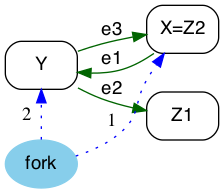

------------------------------------------------------------
------------------------------------------------------------

PW: 4

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","Y"). e("Y","Z1"). fork("X","Y").


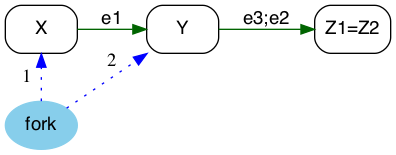

------------------------------------------------------------
------------------------------------------------------------

PW: 5

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","Y"). e("Y","Y"). e("Y","Z2"). fork("X","Y").


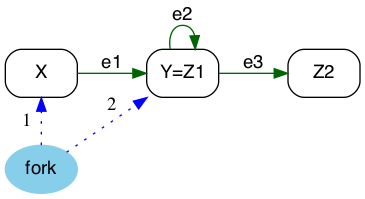

------------------------------------------------------------
------------------------------------------------------------

PW: 6

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","Y"). e("Y","Y"). fork("X","Y").


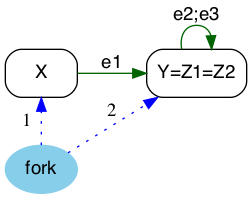

------------------------------------------------------------
------------------------------------------------------------

PW: 7

Partitioning Description:


Specialized Query:


Canonical DB:
e("Y","X"). e("X","Y"). e("Y","Y"). fork("X","Y").


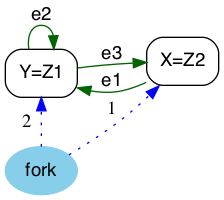

------------------------------------------------------------
------------------------------------------------------------

PW: 8

Partitioning Description:


Specialized Query:


Canonical DB:
e("Y","X"). e("X","Y"). e("Y","Z2"). fork("X","Y").


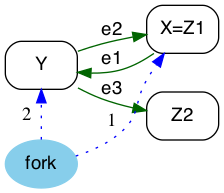

------------------------------------------------------------
------------------------------------------------------------

PW: 9

Partitioning Description:


Specialized Query:


Canonical DB:
e("Y","X"). e("X","Y"). e("Y","Y"). fork("X","Y").


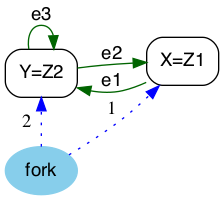

------------------------------------------------------------
------------------------------------------------------------

PW: 10

Partitioning Description:


Specialized Query:


Canonical DB:
e("Y","X"). e("X","Y"). fork("X","Y").


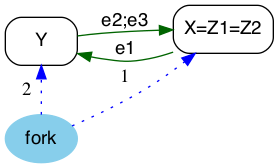

------------------------------------------------------------
------------------------------------------------------------

PW: 11

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","X"). e("X","Z1"). e("X","Z2"). fork("X","X").


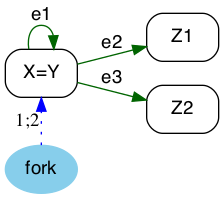

------------------------------------------------------------
------------------------------------------------------------

PW: 12

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","X"). e("X","Z1"). fork("X","X").


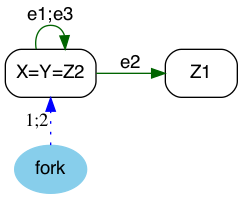

------------------------------------------------------------
------------------------------------------------------------

PW: 13

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","X"). e("X","Z1"). fork("X","X").


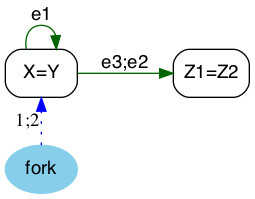

------------------------------------------------------------
------------------------------------------------------------

PW: 14

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","X"). e("X","Z2"). fork("X","X").


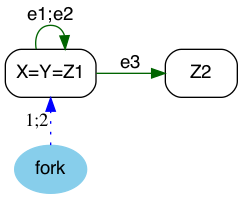

------------------------------------------------------------
------------------------------------------------------------

PW: 15

Partitioning Description:


Specialized Query:


Canonical DB:
e("X","X"). fork("X","X").


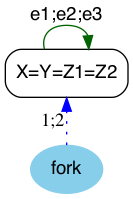

------------------------------------------------------------


In [15]:
for i in range(1, len(query_analysis['pw_objs'])+1):
    print('-'*60)
    print("\nPW:", i)
    pw_rel_dfs, pw_objs = pw_slicer(query_analysis['pw_rel_dfs'], query_analysis['pw_objs'], [i])
    pw_obj = pw_objs[0]
    
    print("\nPartitioning Description:")
    print_fancy_rewrite(pw_rel_dfs)
    
    print("Specialized Query:")
    print_explicit_rewritten_query_string(pw_rel_dfs, chain_eq=False)
    
    print("Canonical DB:")
    pw_edge_facts = get_edge_facts(pw_obj)
    pw_head_facts = get_query_head_facts(pw_obj)
    print(" ".join(pw_edge_facts+pw_head_facts))
    g = get_pattern_graph3(pw_rel_dfs, pw_obj, silent=True, q_head='hyperedge')
    # draw(g, filename='{}.{}'.format('3hop_all_patterns_new/pw_{}'.format(i), 'png'), show=False)
    display(draw(g))
    print('-'*60)

In [56]:
pw_id_to_head_encoding = {
    1: "abcd",
    2: "abcb",
    3: "abca",
    4: "abcc",
    5: "abbc",
    6: "abbb",
    7: "abba",
    8: "abac",
    9: "abab",
    10: "abaa",
    11: "aabc",
    12: "aaba",
    13: "aabb",
    14: "aaab",
    15: "aaaa",
}

In [57]:
pw_id_to_encoding = pw_id_to_head_encoding

Above, we can see for each PW, the variable partitions (in blue), followed by the specialized query the PW represents, followed by a textual and visual representation of the canonical database of the specialized query.

These visual representations of the canonical databases are what we call ___graph-patterns___.

One outstanding issue is that these specialized queries/patterns aren't disjoint, _yet_, i.e. some of them are equivalent. To find the set of disjoint set of these specialized queries/patterns, we check for isomorphisms between these canonical databases. If there exists an isomorphism between two canonical databases (and hence the graph patterns), the two specialized queries (and the graph patterns) are equivalent, and can be grouped together.

Below is the encoding that checks if there exists such an isomorphism for two such canonical databases:

In [18]:
def create_isomorphism_equivalence_encoding(asp_rule, show_nothing_rule=True):
    listener = parse_dlv_rules(asp_rule, print_parse_tree=False)
    
    logic_atom_types = set([])
    
    assert len(listener.rules) == 1
    
    for rule in listener.rules:
        head_atoms, tail_atoms = rule[0], rule[1]
        for ruleOcc in head_atoms+tail_atoms:
            logic_atom_types.add((ruleOcc.rel_name, ruleOcc.rel_arity))
    
    gnode_rules = []
    vmap_rules = ['vmap(X,Y) ; not vmap(X,Y) :- gnode1(X), gnode2(Y).']
    many_to_one_cond_rule = [
        ':- gnode1(X), #count {Y: vmap(X,Y)} != 1.',
        ':- gnode2(Y), #count {X: vmap(X,Y)} != 1.',
    ]
    show_rule = ['#show.'] if show_nothing_rule else []
    
    for logic_atom, arity in logic_atom_types:
        
        for qid in [1,2]:
            t = ['_' for _ in range(arity)]
            for pos in range(arity):
                t[pos] = 'X'
                body = ','.join(t)
                gnode_rules.append(f'gnode{qid}(X) :- {logic_atom}{qid}({body}).')
                t[pos] = '_'
        
        tx, ty = [f'X{i+1}' for i in range(arity)], [f'Y{i+1}' for i in range(arity)]
        l_vmaps = ', '.join([f'vmap({ti_x},{ti_y})' for ti_x, ti_y in zip(tx,ty)])
        tx_j, ty_j = ','.join(tx), ','.join(ty)
        if arity > 0:
            vmap_rules.append(f':- {l_vmaps}, {logic_atom}1({tx_j}), not {logic_atom}2({ty_j}).')
            vmap_rules.append(f':- {l_vmaps}, not {logic_atom}1({tx_j}), {logic_atom}2({ty_j}).')
        elif arity == 0:
            vmap_rules.append(f':- {logic_atom}1, not {logic_atom}2.')
            vmap_rules.append(f':- not {logic_atom}1, {logic_atom}2.')
        

        
    return gnode_rules + vmap_rules + many_to_one_cond_rule + show_rule

In [19]:
qep_eq_check = create_isomorphism_equivalence_encoding(query_str)
qep_eq_check = '\n'.join(qep_eq_check)
ASPRules(qep_eq_check)

'gnode1(X) :- fork1(X,_).\ngnode1(X) :- fork1(_,X).\ngnode2(X) :- fork2(X,_).\ngnode2(X) :- fork2(_,X).\ngnode1(X) :- e1(X,_).\ngnode1(X) :- e1(_,X).\ngnode2(X) :- e2(X,_).\ngnode2(X) :- e2(_,X).\nvmap(X,Y) ; not vmap(X,Y) :- gnode1(X), gnode2(Y).\n:- vmap(X1,Y1), vmap(X2,Y2), fork1(X1,X2), not fork2(Y1,Y2).\n:- vmap(X1,Y1), vmap(X2,Y2), not fork1(X1,X2), fork2(Y1,Y2).\n:- vmap(X1,Y1), vmap(X2,Y2), e1(X1,X2), not e2(Y1,Y2).\n:- vmap(X1,Y1), vmap(X2,Y2), not e1(X1,X2), e2(Y1,Y2).\n:- gnode1(X), #count {Y: vmap(X,Y)} != 1.\n:- gnode2(Y), #count {X: vmap(X,Y)} != 1.\n#show.'

We can now use PWE to compute the disjoint groups efficiently using the above encoding:

In [20]:
sets = get_equivalent_sets(query_analysis['pw_objs'], lambda pw1, pw2: are_equivalent_patterns(pw1,pw2,qep_eq_check))

In [21]:
for s in sets:
    print({pw.pw_id for pw in s})

{1}
{2, 5}
{8, 3}
{4}
{6}
{9, 7}
{10}
{11}
{12, 13, 14}
{15}


In [22]:
len(sets)

10

--

------------------------------------------------------------------------------------------
------------------------------------------------------------

PW: 5
Canonical DB:
e("X","Y"). e("Y","Y"). e("Y","Z2"). fork("X","Y").


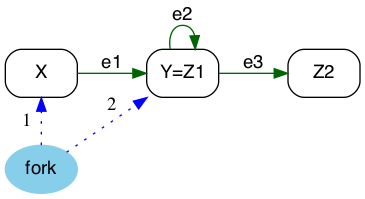

------------------------------------------------------------
------------------------------------------------------------

PW: 2
Canonical DB:
e("X","Y"). e("Y","Y"). e("Y","Z1"). fork("X","Y").


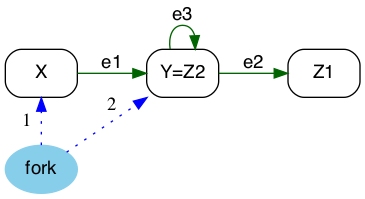

------------------------------------------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------

PW: 3
Canonical DB:
e("Y","X"). e("X","Y"). e("Y","Z1"). fork("X","Y").


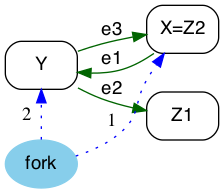

------------------------------------------------------------
------------------------------------------------------------

PW: 8
Canonical DB:
e("Y","X"). e("X","Y"). e("Y","Z2"). fork("X","Y").


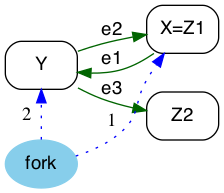

------------------------------------------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------

PW: 9
Canonical DB:
e("Y","X"). e("X","Y"). e("Y","Y"). fork("X","Y").


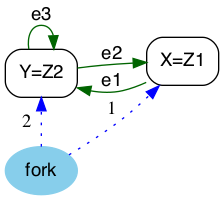

------------------------------------------------------------
------------------------------------------------------------

PW: 7
Canonical DB:
e("Y","X"). e("X","Y"). e("Y","Y"). fork("X","Y").


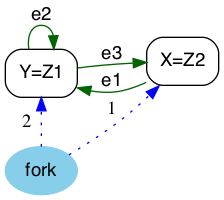

------------------------------------------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
------------------------------------------------------------

PW: 12
Canonical DB:
e("X","X"). e("X","Z1"). fork("X","X").


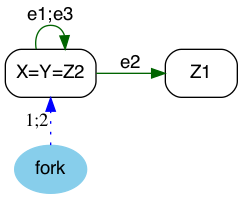

------------------------------------------------------------
------------------------------------------------------------

PW: 13
Canonical DB:
e("X","X"). e("X","Z1"). fork("X","X").


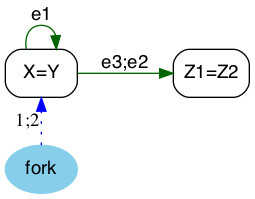

------------------------------------------------------------
------------------------------------------------------------

PW: 14
Canonical DB:
e("X","X"). e("X","Z2"). fork("X","X").


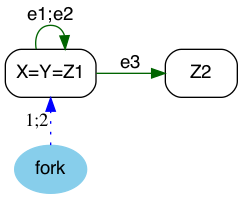

------------------------------------------------------------
------------------------------------------------------------------------------------------


In [23]:
for s in sets:
    if len(s) > 1:
        print('-'*90)
        for pw in s:
            i = pw.pw_id
            print('-'*60)
            print("\nPW:", i)
            pw_rel_dfs, pw_objs = pw_slicer(query_analysis['pw_rel_dfs'], query_analysis['pw_objs'], [i])
            pw_obj = pw_objs[0]

            print("Canonical DB:")
            pw_edge_facts = get_edge_facts(pw_obj)
            pw_head_facts = get_query_head_facts(pw_obj)
            print(" ".join(pw_edge_facts+pw_head_facts))
            g = get_pattern_graph3(pw_rel_dfs, pw_obj, silent=True, q_head='hyperedge')
            display(draw(g))
            print('-'*60)
        print('-'*90)

### Building a hierarchy of _semi_-specialized queries

In the specialized queries above, we explicitly encode the equalities and in/dis-equalities between the variables in the query. Say we only encode the equalities but not the in/dis-equalities. This gives us a set of _semi_-specialized queries which can be arranged in a hierarchy based on query containment relations. We build these queries and their hierarchy below.

Below is an ASP encoding to check for query containment between two queries Q1 and Q2 (is Q2 contained in Q1?) based on their canonical databases:

In [24]:
def create_homomorphism_containment_encoding(asp_rule, show_nothing_rule=True):
    listener = parse_dlv_rules(asp_rule, print_parse_tree=False)
    
    logic_atom_types = set([])
    
    assert len(listener.rules) == 1
    
    for rule in listener.rules:
        head_atoms, tail_atoms = rule[0], rule[1]
        for ruleOcc in head_atoms+tail_atoms:
            logic_atom_types.add((ruleOcc.rel_name, ruleOcc.rel_arity))
    
    gnode_rules = []
    vmap_rules = ['vmap(X,Y) ; not vmap(X,Y) :- gnode1(X), gnode2(Y).']
    vmap_q1_q2_rules = []
    vmap_q2_q1_rules = []
    many_to_one_cond_rule = [':- gnode1(X), #count {Y: vmap(X,Y)} != 1.']
    show_rule = ['#show.'] if show_nothing_rule else []
    
    for logic_atom, arity in logic_atom_types:
        
        for qid in [1,2]:
            t = ['_' for _ in range(arity)]
            for pos in range(arity):
                t[pos] = 'X'
                body = ','.join(t)
                gnode_rules.append(f'gnode{qid}(X) :- {logic_atom}{qid}({body}).')
                t[pos] = '_'
        
        tx, ty = [f'X{i+1}' for i in range(arity)], [f'Y{i+1}' for i in range(arity)]
        l_vmaps = ', '.join([f'vmap({ti_x},{ti_y})' for ti_x, ti_y in zip(tx,ty)])
        tx_j, ty_j = ','.join(tx), ','.join(ty)
        l_gnode2s = ', '.join([f'gnode2({ti_y})' for ti_y in ty])
        
        if arity > 0:
            vmap_q1_q2_rules.append(f':- {l_vmaps}, {logic_atom}1({tx_j}), not {logic_atom}2({ty_j}).')
            #vmap_q2_q1_rules.append(f'{logic_atom}2_mapped({ty_j}) :- {l_vmaps}, {logic_atom}1({tx_j}), {logic_atom}2({ty_j}).')
            #vmap_q2_q1_rules.append(f':- {l_gnode2s}, {logic_atom}2({ty_j}), not {logic_atom}2_mapped({ty_j}).')
        elif arity == 0:
            vmap_q1_q2_rules.append(f':- {logic_atom}1, not {logic_atom}2.')
            #vmap_q2_q1_rules.append(f'{logic_atom}2_mapped :- {logic_atom}1, {logic_atom}2.')
            #vmap_q2_q1_rules.append(f':- {logic_atom}2, not {logic_atom}2_mapped.')

        
    return gnode_rules + vmap_rules + vmap_q1_q2_rules + vmap_q2_q1_rules + many_to_one_cond_rule + show_rule

In [25]:
qep_containment_check = create_homomorphism_containment_encoding(query_str, show_nothing_rule=False)
qep_containment_check = '\n'.join(qep_containment_check)
ASPRules(qep_containment_check)

'gnode1(X) :- fork1(X,_).\ngnode1(X) :- fork1(_,X).\ngnode2(X) :- fork2(X,_).\ngnode2(X) :- fork2(_,X).\ngnode1(X) :- e1(X,_).\ngnode1(X) :- e1(_,X).\ngnode2(X) :- e2(X,_).\ngnode2(X) :- e2(_,X).\nvmap(X,Y) ; not vmap(X,Y) :- gnode1(X), gnode2(Y).\n:- vmap(X1,Y1), vmap(X2,Y2), fork1(X1,X2), not fork2(Y1,Y2).\n:- vmap(X1,Y1), vmap(X2,Y2), e1(X1,X2), not e2(Y1,Y2).\n:- gnode1(X), #count {Y: vmap(X,Y)} != 1.'

In [26]:
# Function to test whether query Q1 (represented by pw1) contains query Q2 (represented by pw2)
# using the above encoding
def q1_contains_q2(pw1, pw2):
    return are_equivalent_patterns(pw1, pw2, qep_containment_check)

In [27]:
def get_canonical_db(pw_rel_dfs, include_head=True):
    canonical_db = {}
    for _, row in pw_rel_dfs['newArc_4'].iterrows():
        rule = (row['ATOM'], int(row['OCC']))
        pos = int(row['POS'])
        var = row['VAR']
        if rule not in canonical_db:
            canonical_db[rule] = {}
        canonical_db[rule][pos] = var
    
    if include_head:
        if 'ruleH_1' in pw_rel_dfs:
            for _, row in pw_rel_dfs['ruleH_1'].iterrows():
                rule = row['HEAD']
                if rule not in canonical_db:
                    canonical_db[rule] = {}
        if 'newHArc_3' in pw_rel_dfs:
            for _, row in pw_rel_dfs['newHArc_3'].iterrows():
                rule = row['HEAD']
                pos = int(row['POS'])
                var = row['VAR']
                if rule not in canonical_db:
                    canonical_db[rule] = {}
                canonical_db[rule][pos] = var

    canonical_db_fact_strs = []
    for rule, rule_desc in canonical_db.items():
        if isinstance(rule, tuple):
            rule = rule[0]
        r_body = [rule_desc[k] for k in sorted(rule_desc.keys())]
        if len(r_body) > 0:
            r_body_j = ', '.join(r_body)
            canonical_db_fact_strs.append(f'{rule}({r_body_j}).')
        else:
            canonical_db_fact_strs.append(f'{rule}.')
        
    return canonical_db_fact_strs

In [28]:
def canonical_db_containment_check(pw1_rel_dfs, pw2_rel_dfs):
    """
    Q1 (pw1) contains Q2 (pw2)
    """
    pw1_q_str = print_rewritten_query_string(pw1_rel_dfs, html=False, display_q=False, include_ineqls=False)
    pw2_canonical_db = get_canonical_db(pw2_rel_dfs, include_head=True)
    sat_req_rule = ''
    show_rule = ''
    assert len(pw1_rel_dfs['ruleH_1']) > 0
    q1_head = pw1_rel_dfs['ruleH_1']['HEAD'][0]
    
    pw1_q_str = pw1_q_str.replace(q1_head, f'{q1_head}_q')
    
    if 'newHArc_3' in pw1_rel_dfs and len(pw1_rel_dfs['newHArc_3']) > 0:
        q1_head_arity = len(pw1_rel_dfs['newHArc_3']['POS'])
        h_vars = [f'A{i}' for i in range(q1_head_arity)]
        h_vars_j = ','.join(h_vars)
        sat_req_rule = f':- not {q1_head}_q({h_vars_j}), {q1_head}({h_vars_j}).'
    else:
        sat_req_rule = f':- not {q1_head}_q, {q1_head}.'
    
    #print("\n".join([pw1_q_str]+pw2_canonical_db+[sat_req_rule]))
    asp_out, _ = run_clingo([pw1_q_str]+pw2_canonical_db+[sat_req_rule, show_rule], num_solutions=1)
    #print(asp_out)
    _,_,eq_check_pws = load_worlds(asp_out, silent=True)
    
    return len(eq_check_pws) >= 1

def canonical_db_containment_check_wrapper(pw_rel_dfs, pw1_id, pw2_id):
    
    pw1_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [pw1_id])[0]
    pw2_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [pw2_id])[0]
    return canonical_db_containment_check(pw1_rel_dfs, pw2_rel_dfs)

In [29]:
# Save figures for each PW (to build the hierarchy)

query_fig_fnames = save_query_figs(query_analysis, folder='fork_2_all_patterns_new')

Next, we create the hierarchy of the queries:

In [30]:
g = nx.DiGraph()
for pw_id in range(1, len(query_analysis['pw_objs'])+1):
    fname = query_fig_fnames[pw_id]
    g.add_node(pw_id, image=os.path.abspath(fname),
               shape='box', fixedsize='true', imagescale='true', size=2, label=" ")

Let's add edges based on query containment between all the queries:

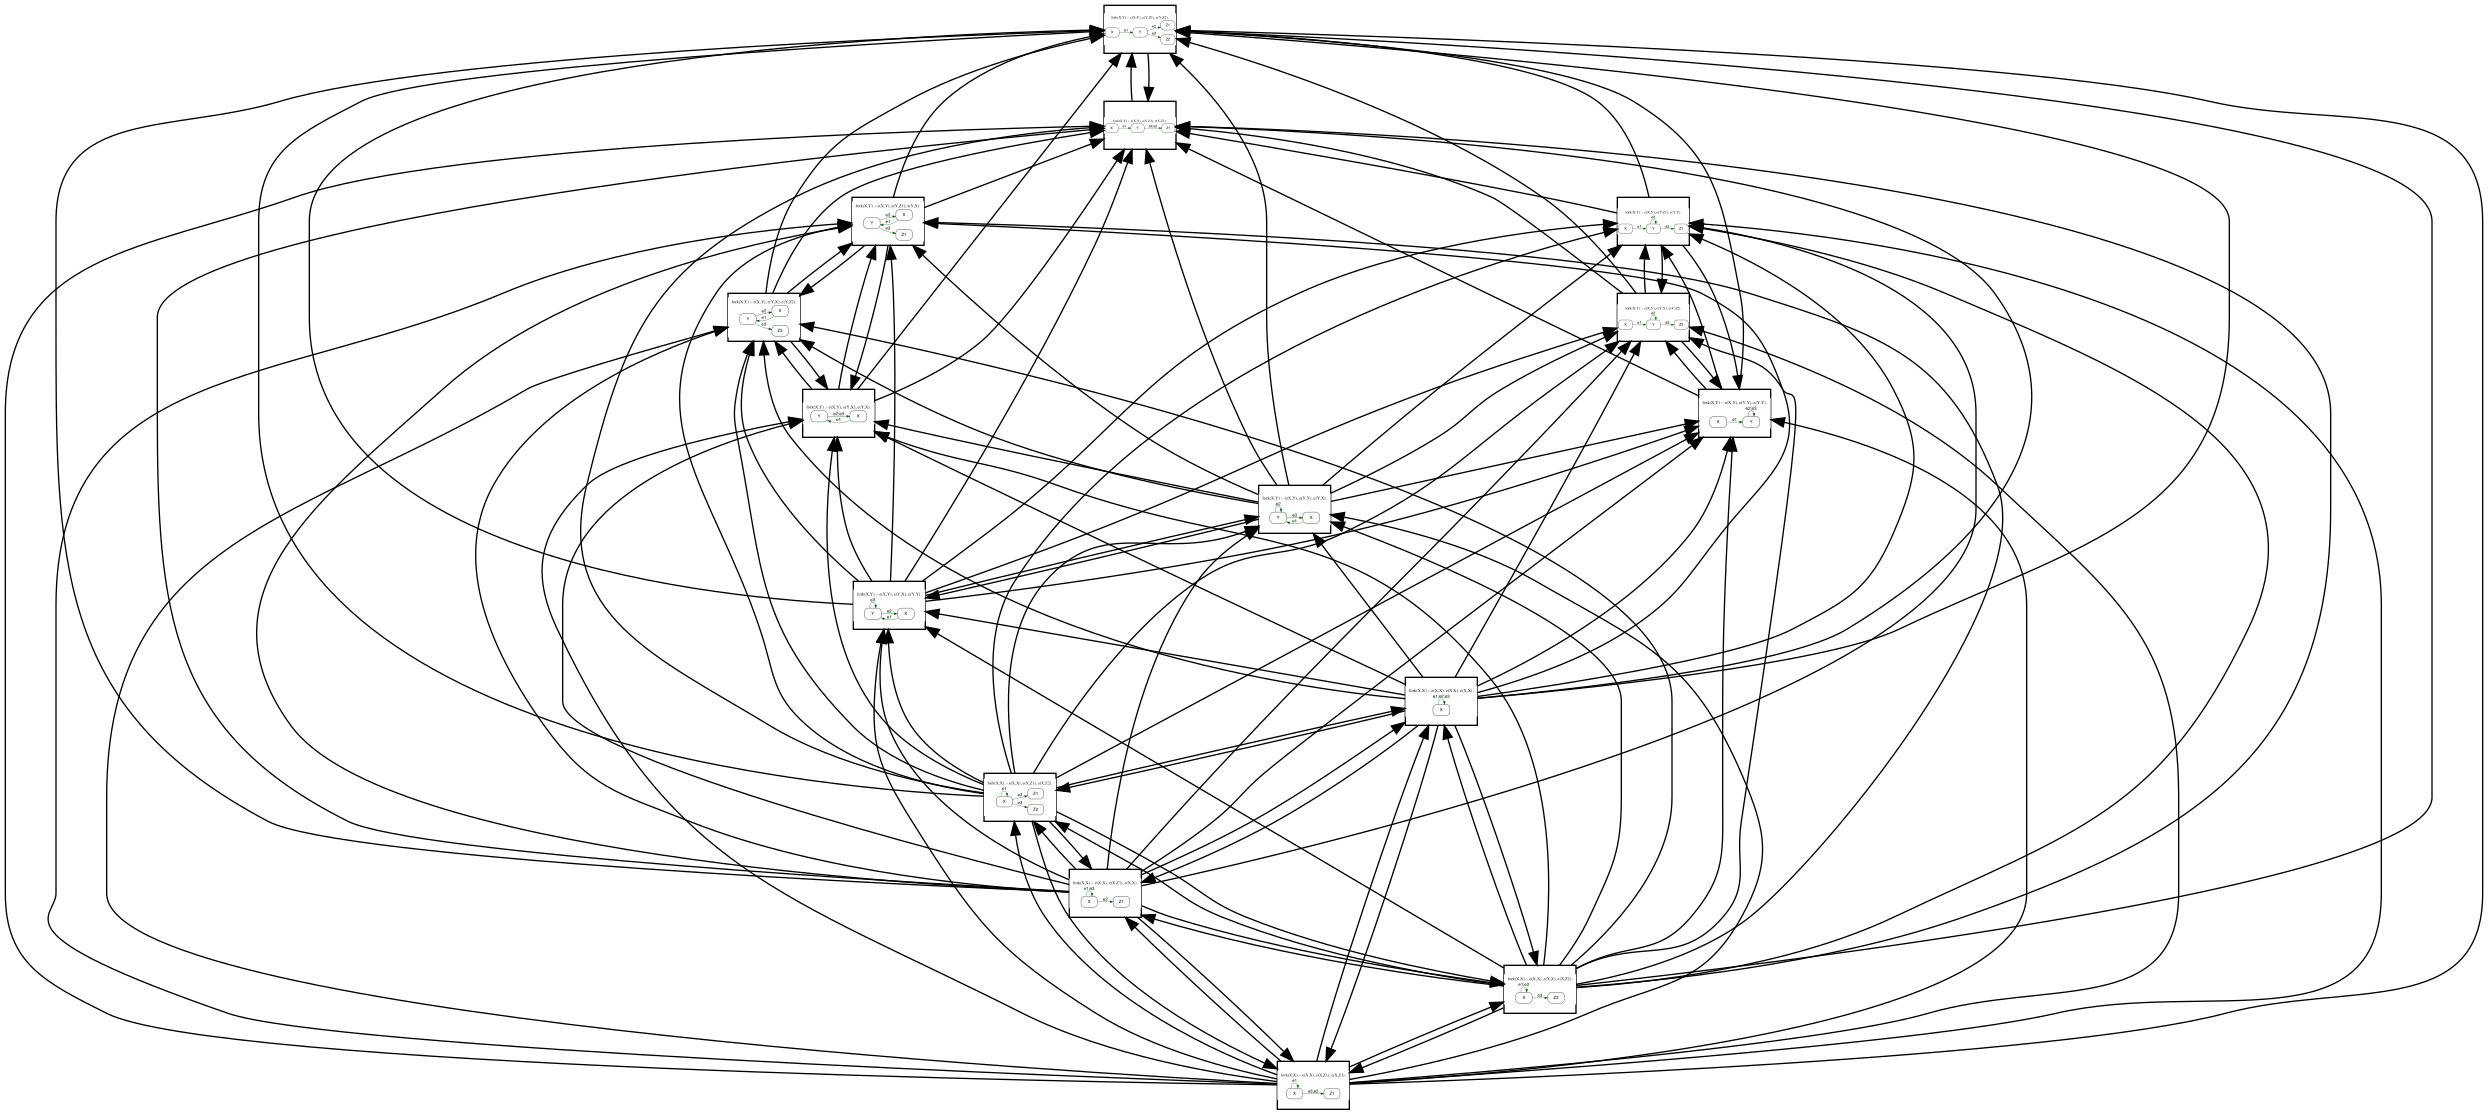

In [31]:
for pw_id1 in range(1, len(query_analysis['pw_objs'])+1):
    for pw_id2 in range(1, len(query_analysis['pw_objs'])+1):
        if pw_id1 == pw_id2:
            continue
        if canonical_db_containment_check_wrapper(query_analysis['pw_rel_dfs'], pw_id1, pw_id2):
            g.add_edge(pw_id1, pw_id2, dir='back')

draw(g)

In [32]:
keep_running = True

while keep_running:
    keep_running=False
    for eu, ev in list(g.edges):
        if (ev,eu) in list(g.edges):
            print(f"Merging {eu} and {ev}")
            g = nx.contracted_nodes(g, min(eu,ev), max(eu,ev), self_loops=False)
            keep_running = True
            break

Merging 1 and 4
Merging 2 and 5
Merging 2 and 6
Merging 3 and 8
Merging 3 and 10
Merging 7 and 9
Merging 11 and 12
Merging 11 and 13
Merging 11 and 14
Merging 11 and 15


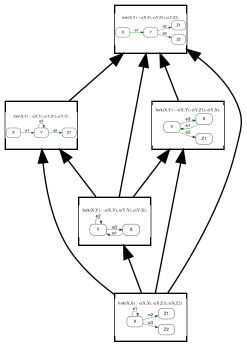

In [33]:
draw(g)

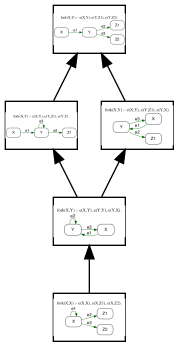

In [34]:
g_ = nx.algorithms.dag.transitive_reduction(g)

# Copy over the style properties (the nx.algorithms.dag.transitive_reduction loses these)
for n in g.nodes:
    for k,v in g.nodes[n].items():
        g_.nodes[n][k] = v
for e in g_.edges:
    g_.edges[e]['dir'] = 'back'
draw(g_)

In [35]:
draw(g_, filename='fork_2_query_hierarchy_can_db_v2.pdf', show=False)

'fork_2_query_hierarchy_can_db_v2.pdf'

In [36]:
draw(g_, filename='fork_2_query_hierarchy_can_db_v2.gv', show=False)

'fork_2_query_hierarchy_can_db_v2.gv'

In [38]:
g = nx.DiGraph()
for pw_id in range(1, len(query_analysis['pw_objs'])+1):
    fname = query_fig_fnames[pw_id]
    g.add_node(pw_id, image=os.path.abspath(fname),
               shape='box', fixedsize='true', imagescale='true', size=2, label=" ")

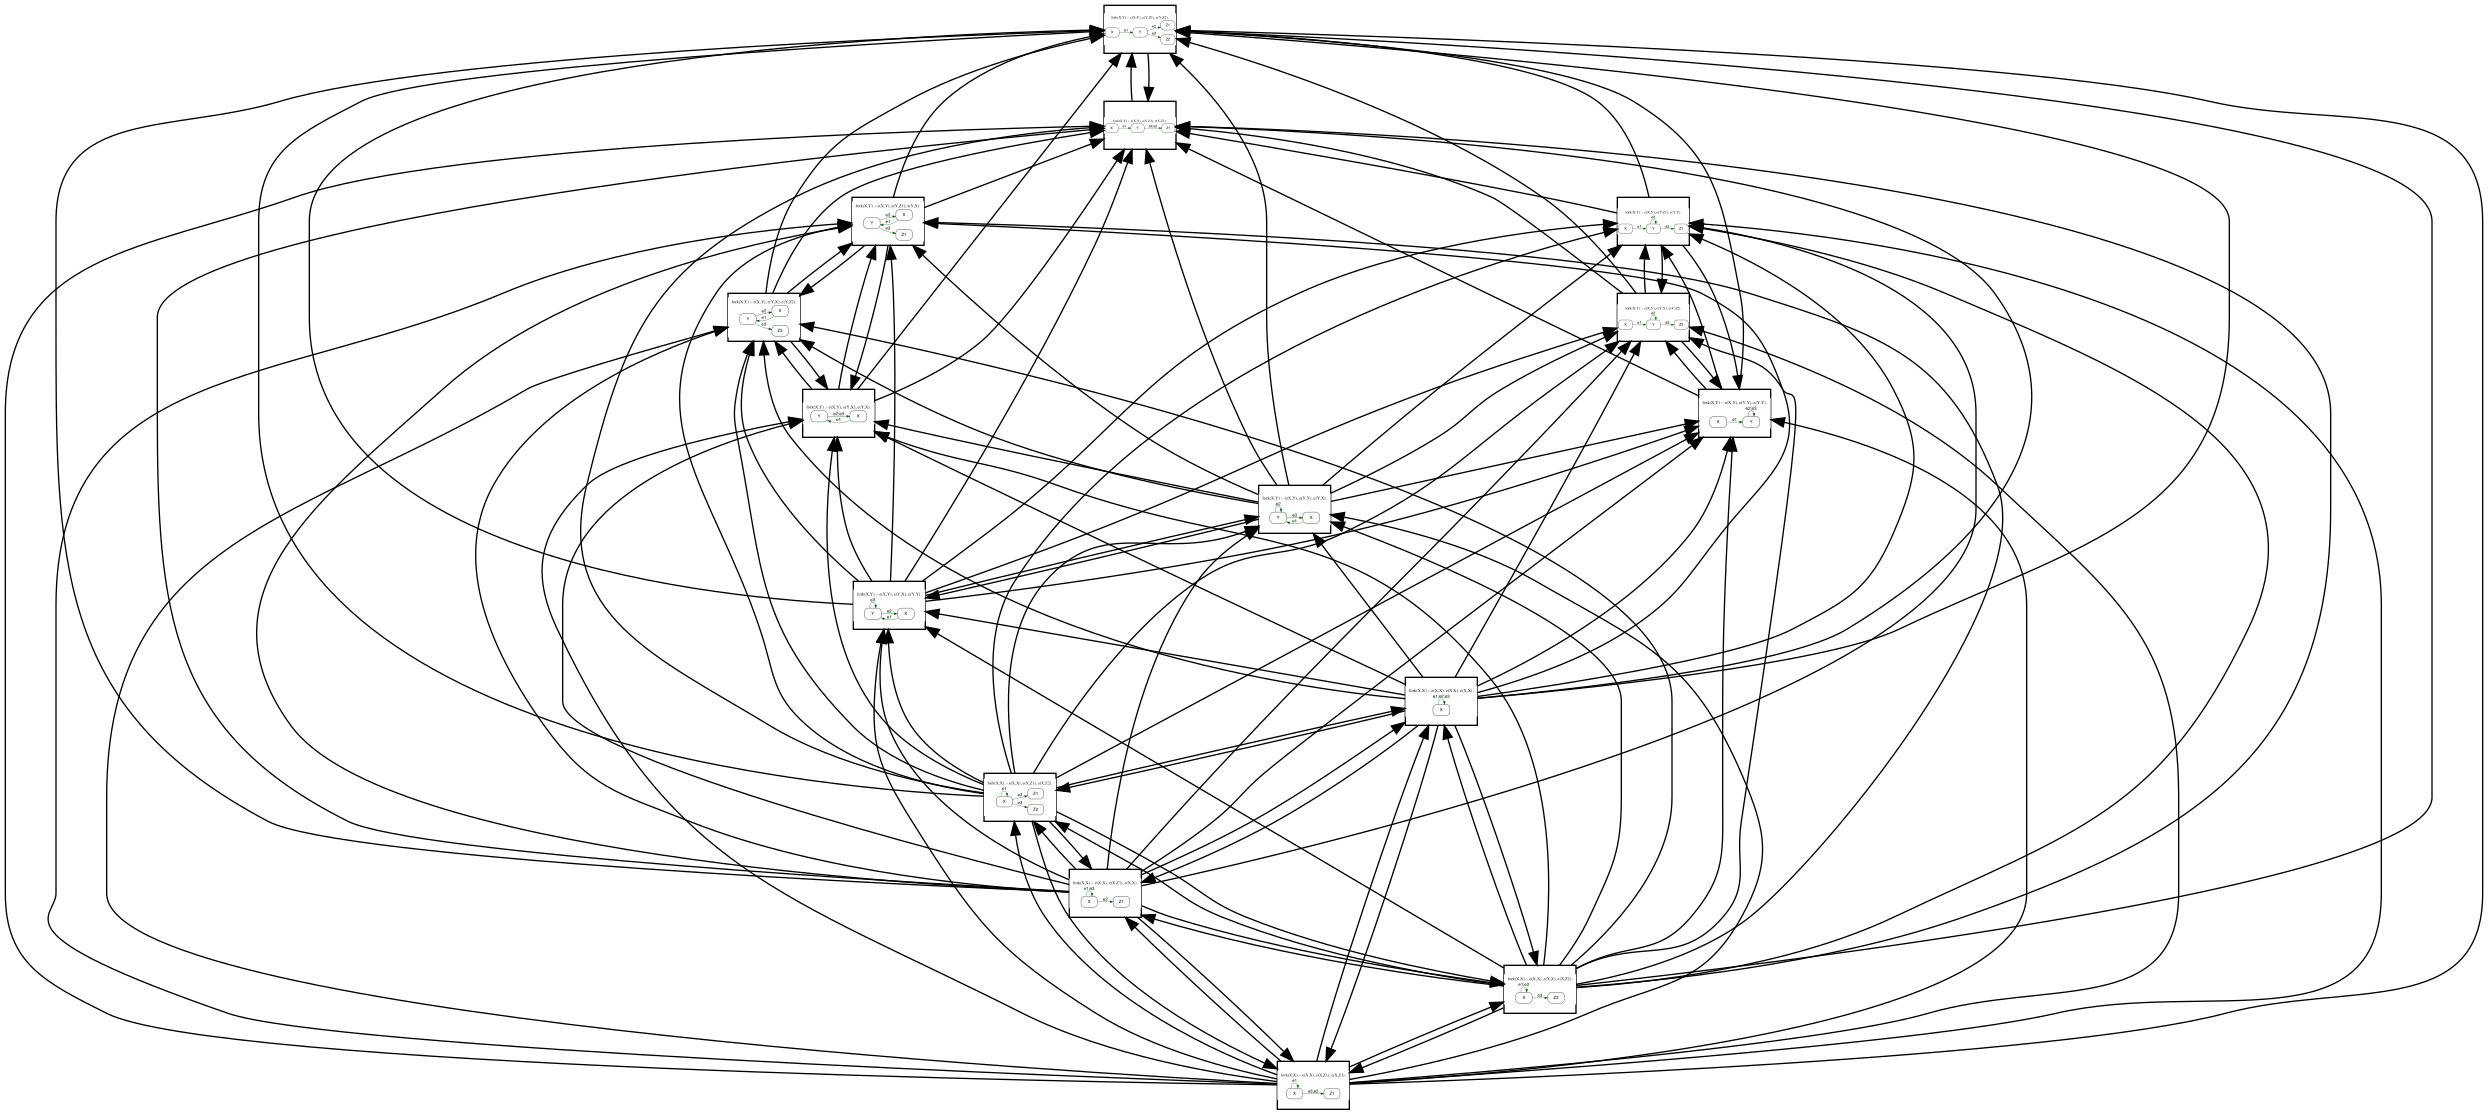

In [39]:
for pw_id1 in range(1, len(query_analysis['pw_objs'])+1):
    for pw_id2 in range(1, len(query_analysis['pw_objs'])+1):
        if pw_id1 == pw_id2:
            continue
        if q1_contains_q2(query_analysis['pw_objs'][pw_id1-1], query_analysis['pw_objs'][pw_id2-1]):
            g.add_edge(pw_id1, pw_id2, dir='back')

draw(g)

In [40]:
keep_running = True

while keep_running:
    keep_running=False
    for eu, ev in list(g.edges):
        if (ev,eu) in list(g.edges):
            print(f"Merging {eu} and {ev}")
            g = nx.contracted_nodes(g, min(eu,ev), max(eu,ev), self_loops=False)
            keep_running = True
            break

Merging 1 and 4
Merging 2 and 5
Merging 2 and 6
Merging 3 and 8
Merging 3 and 10
Merging 7 and 9
Merging 11 and 12
Merging 11 and 13
Merging 11 and 14
Merging 11 and 15


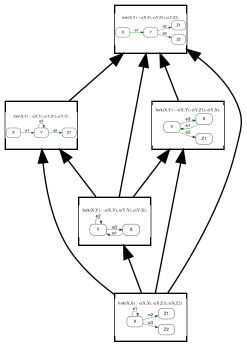

In [41]:
draw(g)

To make the hierarchy easier to analyze, we remove the redundant transitive edges using a transitive reduction.

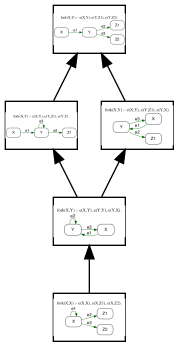

In [42]:
g_ = nx.algorithms.dag.transitive_reduction(g)

# Copy over the style properties (the nx.algorithms.dag.transitive_reduction loses these)
for n in g.nodes:
    for k,v in g.nodes[n].items():
        g_.nodes[n][k] = v
for e in g_.edges:
    g_.edges[e]['dir'] = 'back'
draw(g_)

The arrows can be iterpreted as ___'isa'___ relations.

In [43]:
draw(g_, filename='fork_2_query_hierarchy_homomorphsim.gv', show=False)
draw(g_, filename='fork_2_query_hierarchy_homomorphism.pdf', show=False)

'fork_2_query_hierarchy_homomorphism.pdf'

In [45]:
def get_canonical_db_mod(pw_rel_dfs, include_head=True, pw_id=None):
    canonical_db = {}
    for _, row in pw_rel_dfs['newArc_4'].iterrows():
        rule = (row['ATOM'], int(row['OCC']))
        pos = int(row['POS'])
        var = row['VAR']
        if rule not in canonical_db:
            canonical_db[rule] = {}
        canonical_db[rule][pos] = var
        
    if include_head:
        if 'ruleH_1' in pw_rel_dfs:
            for _, row in pw_rel_dfs['ruleH_1'].iterrows():
                rule = row['HEAD']
                if rule not in canonical_db:
                    canonical_db[rule] = {}
        if 'newHArc_3' in pw_rel_dfs:
            for _, row in pw_rel_dfs['newHArc_3'].iterrows():
                rule = row['HEAD']
                pos = int(row['POS'])
                var = row['VAR']
                if rule not in canonical_db:
                    canonical_db[rule] = {}
                canonical_db[rule][pos] = var
    
#     if include_head and ('newHArc_3' in pw_rel_dfs):
#         for _, row in pw_rel_dfs['newHArc_3'].iterrows():
#             rule = row['HEAD']
#             pos = int(row['POS'])
#             var = row['VAR']
#             if rule not in canonical_db:
#                 canonical_db[rule] = {}
#             canonical_db[rule][pos] = var

    canonical_db_fact_strs = []
    for rule, rule_desc in canonical_db.items():
        if isinstance(rule, tuple):
            rule = rule[0]
        r_body = [rule_desc[k] for k in sorted(rule_desc.keys())]
        if pw_id is not None:
            r_body.insert(0, str(pw_id))
        if len(r_body) > 0:
            r_body_j = ', '.join(r_body)
            canonical_db_fact_strs.append(f'{rule}({r_body_j}).')
        else:
            canonical_db_fact_strs.append(f'{rule}.')
        
    return canonical_db_fact_strs

In [46]:
can_dbs = []
q_strs = []
for i in range(1, len(query_analysis['pw_objs'])+1):
    
    pw_rel_dfs, pw_objs = pw_slicer(query_analysis['pw_rel_dfs'], query_analysis['pw_objs'], [i])
    pw_obj = pw_objs[0]
    pw_can_db = get_canonical_db_mod(pw_rel_dfs, pw_id=i)
    can_dbs.extend(pw_can_db)
    #print(pw_can_db)
    pw_q_str = print_rewritten_query_string(pw_rel_dfs, html=False, display_q=False, include_ineqls=False)
    pw_q_str = pw_q_str.replace('fork(', f'q({i},QID,')
    pw_q_str = pw_q_str.replace('e(', f'e(QID,')
    pw_q_str = pw_q_str.replace('.', ', qid(QID).')
    q_strs.append(pw_q_str)
    #print(pw_q_str)
    

In [47]:
print("\n".join(can_dbs+q_strs))

e(1, "X", "Y").
e(1, "Y", "Z1").
e(1, "Y", "Z2").
fork(1, "X", "Y").
e(2, "X", "Y").
e(2, "Y", "Y").
e(2, "Y", "Z1").
fork(2, "X", "Y").
e(3, "X", "Y").
e(3, "Y", "X").
e(3, "Y", "Z1").
fork(3, "X", "Y").
e(4, "X", "Y").
e(4, "Y", "Z1").
e(4, "Y", "Z1").
fork(4, "X", "Y").
e(5, "X", "Y").
e(5, "Y", "Y").
e(5, "Y", "Z2").
fork(5, "X", "Y").
e(6, "X", "Y").
e(6, "Y", "Y").
e(6, "Y", "Y").
fork(6, "X", "Y").
e(7, "X", "Y").
e(7, "Y", "Y").
e(7, "Y", "X").
fork(7, "X", "Y").
e(8, "X", "Y").
e(8, "Y", "X").
e(8, "Y", "Z2").
fork(8, "X", "Y").
e(9, "X", "Y").
e(9, "Y", "X").
e(9, "Y", "Y").
fork(9, "X", "Y").
e(10, "X", "Y").
e(10, "Y", "X").
e(10, "Y", "X").
fork(10, "X", "Y").
e(11, "X", "X").
e(11, "X", "Z1").
e(11, "X", "Z2").
fork(11, "X", "X").
e(12, "X", "X").
e(12, "X", "Z1").
e(12, "X", "X").
fork(12, "X", "X").
e(13, "X", "X").
e(13, "X", "Z1").
e(13, "X", "Z1").
fork(13, "X", "X").
e(14, "X", "X").
e(14, "X", "X").
e(14, "X", "Z2").
fork(14, "X", "X").
e(15, "X", "X").
e(15, "X", 

In [48]:
def create_containment_aio_encoding(query_str, num_queries):
    listener = parse_dlv_rules(query_str, print_parse_tree=False)
    logic_atom_types = set([])
    
    qid_dec_rule = f'qid(1..{num_queries}).'
    
    assert len(listener.rules) == 1
    rule = listener.rules[0]
    head_atoms = rule[0]
    assert len(head_atoms) == 1
    head_atom = head_atoms[0]
    head_atom_name, head_atom_arity = head_atom.rel_name, head_atom.rel_arity
    
    q_args = ['QID1', 'QID2'] + [f'A{i}' for i in range(head_atom_arity)]
    
    doesnt_contain_rule = 'doesnt_contain(QID1, QID2) :- not q({}), {}({}), qid(QID1), qid(QID2).'.format(','.join(q_args), head_atom_name, ','.join(q_args[1:]))
    contains_rule = 'contains(QID1, QID2) :- not doesnt_contain(QID1, QID2), qid(QID1), qid(QID2), QID1 != QID2.'
    contains_transitive_rule = 'contains(QID1, QID3) :- contains(QID1, QID2), contains(QID2, QID3), qid(QID1), qid(QID2), qid(QID3).'
    
    graphviz_annotations = [
        '%graphviz graph graph_type=directed rankdir=TB',
        '%graphviz edge contains(HEAD, TAIL)'
    ]
    show_rule = '#show contains/2.'
    
    return [qid_dec_rule, doesnt_contain_rule, contains_rule, contains_transitive_rule, *graphviz_annotations, show_rule]

In [49]:
containment_aio = '\n'.join(create_containment_aio_encoding(query_str, len(query_analysis['pw_objs'])))
ASPRules(containment_aio)

'qid(1..15).\ndoesnt_contain(QID1, QID2) :- not q(QID1,QID2,A0,A1), fork(QID2,A0,A1), qid(QID1), qid(QID2).\ncontains(QID1, QID2) :- not doesnt_contain(QID1, QID2), qid(QID1), qid(QID2), QID1 != QID2.\ncontains(QID1, QID3) :- contains(QID1, QID2), contains(QID2, QID3), qid(QID1), qid(QID2), qid(QID3).\n%graphviz graph graph_type=directed rankdir=TB\n%graphviz edge contains(HEAD, TAIL)\n#show contains/2.'

In [50]:
%clingo --donot-display_input -l can_dbs q_strs containment_aio -exp containment_exp

Output:


'Answer: 1\ncontains(4,1) contains(1,2) contains(4,2) contains(5,2) contains(6,2) contains(1,3) contains(4,3) contains(8,3) contains(10,3) contains(1,4) contains(1,5) contains(2,5) contains(4,5) contains(6,5) contains(1,6) contains(2,6) contains(4,6) contains(5,6) contains(1,7) contains(2,7) contains(3,7) contains(4,7) contains(5,7) contains(6,7) contains(8,7) contains(9,7) contains(10,7) contains(1,8) contains(3,8) contains(4,8) contains(10,8) contains(1,9) contains(2,9) contains(3,9) contains(4,9) contains(5,9) contains(6,9) contains(7,9) contains(8,9) contains(10,9) contains(1,10) contains(3,10) contains(4,10) contains(8,10) contains(1,11) contains(2,11) contains(3,11) contains(4,11) contains(5,11) contains(6,11) contains(7,11) contains(8,11) contains(9,11) contains(10,11) contains(12,11) contains(13,11) contains(14,11) contains(15,11) contains(1,12) contains(2,12) contains(3,12) contains(4,12) contains(5,12) contains(6,12) contains(7,12) contains(8,12) contains(9,12) contains(10,12) contains(11,12) contains(13,12) contains(14,12) contains(15,12) contains(1,13) contains(2,13) contains(3,13) contains(4,13) contains(5,13) contains(6,13) contains(7,13) contains(8,13) contains(9,13) contains(10,13) contains(11,13) contains(12,13) contains(14,13) contains(15,13) contains(1,14) contains(2,14) contains(3,14) contains(4,14) contains(5,14) contains(6,14) contains(7,14) contains(8,14) contains(9,14) contains(10,14) contains(11,14) contains(12,14) contains(13,14) contains(15,14) contains(1,15) contains(2,15) contains(3,15) contains(4,15) contains(5,15) contains(6,15) contains(7,15) contains(8,15) contains(9,15) contains(10,15) contains(11,15) contains(12,15) contains(13,15) contains(14,15) contains(15,15) contains(14,14) contains(13,13) contains(12,12) contains(11,11) contains(10,10) contains(9,9) contains(8,8) contains(7,7) contains(6,6) contains(5,5) contains(4,4) contains(3,3) contains(2,2) contains(1,1)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.005s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.005s'

In [51]:
containment_exp['pw_rel_dfs'], containment_exp['rel_schema'], containment_exp['pw_objs'] =load_worlds(containment_exp['asp_soln'],
                                                                                                   containment_exp['meta_data'])


Number of Models: 1


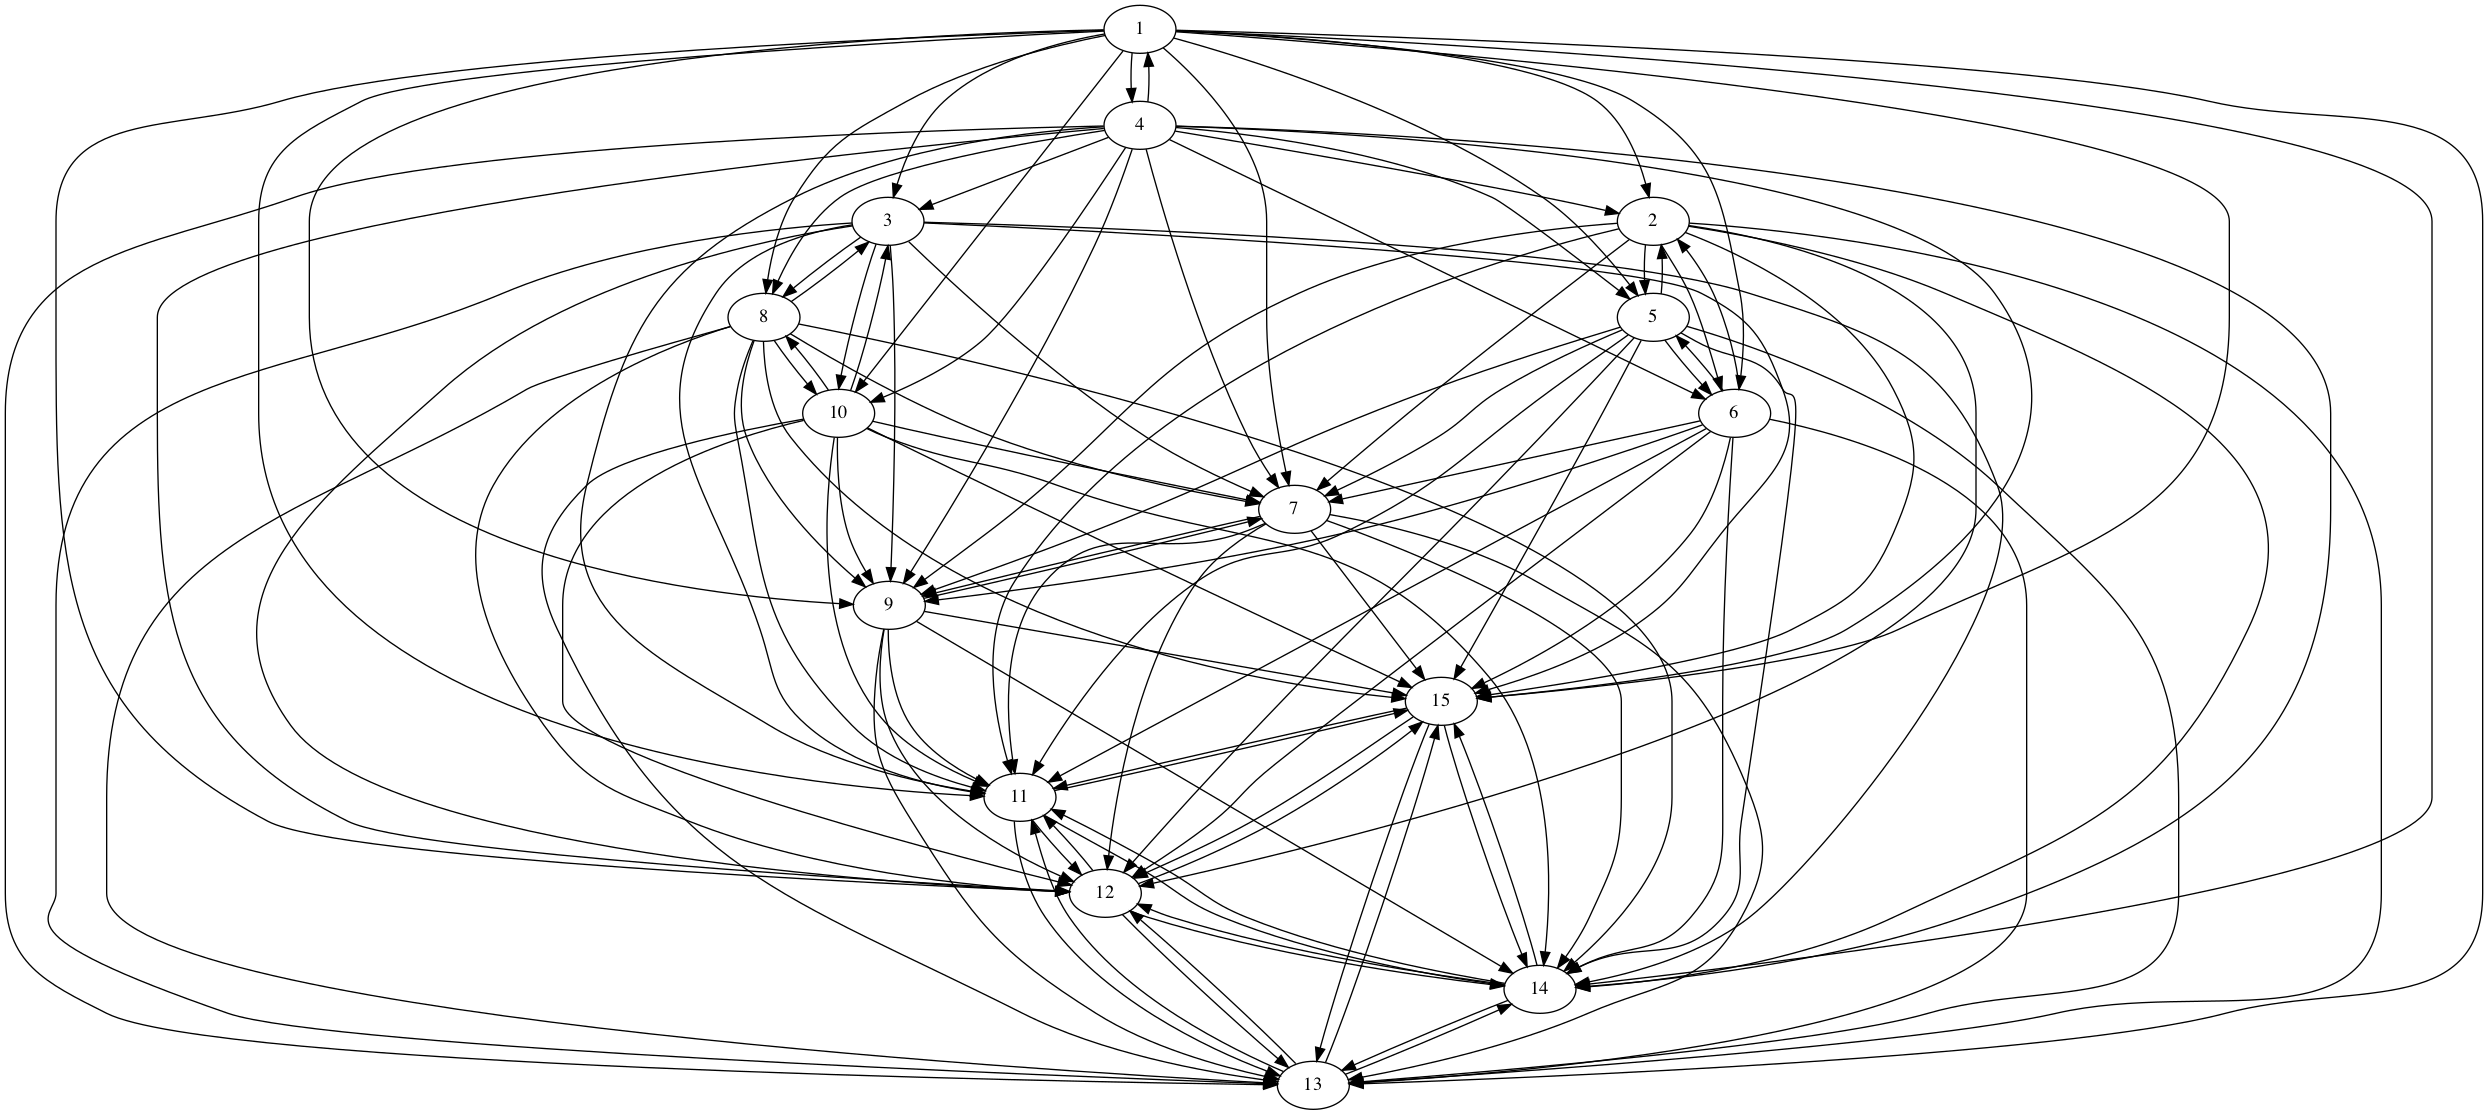

In [52]:
containment_exp_g = nx.DiGraph()
containment_exp_g.add_nodes_from(range(1, len(query_analysis['pw_objs'])+1))
for _, row in containment_exp['pw_rel_dfs']['contains_2'].iterrows():
    if int(row['x1']) != int(row['x2']):
        containment_exp_g.add_edge(int(row['x1']), int(row['x2']))

draw(containment_exp_g)

Merging 1 and 4
Merging 2 and 5
Merging 2 and 6
Merging 3 and 8
Merging 3 and 10
Merging 7 and 9
Merging 11 and 12
Merging 11 and 13
Merging 11 and 14
Merging 11 and 15


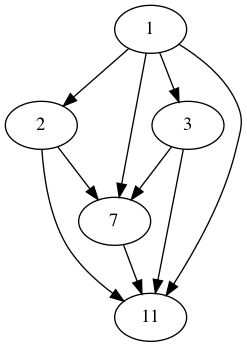

In [53]:
keep_running = True
while keep_running:
    keep_running=False
    for eu, ev in list(containment_exp_g.edges):
        if eu == ev:
            continue
        if (ev,eu) in list(containment_exp_g.edges):
            print(f"Merging {eu} and {ev}")
            containment_exp_g = nx.contracted_nodes(containment_exp_g, min(eu,ev), max(eu,ev), self_loops=False)
            keep_running = True
            break

draw(containment_exp_g)

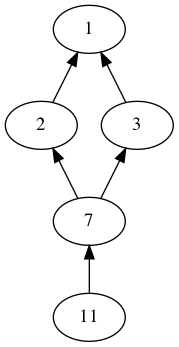

In [54]:
g_ = nx.algorithms.dag.transitive_reduction(containment_exp_g)

# Copy over the style properties (the nx.algorithms.dag.transitive_reduction loses these)
# for n in g.nodes:
#     for k,v in g.nodes[n].items():
#         g_.nodes[n][k] = v
for e in g_.edges:
    g_.edges[e]['dir'] = 'back'
draw(g_)

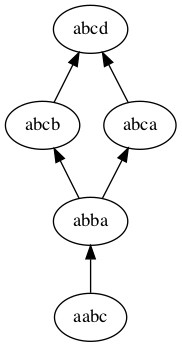

In [58]:
g_head_encoding = g_.copy()
for n in g_head_encoding.nodes.keys():
    g_head_encoding.nodes[n]['label'] = pw_id_to_head_encoding[int(n)]
draw(g_head_encoding)